In [2]:
from library_dicom.rtss_processor.model.MaskBuilder_RTSS import MaskBuilder_RTSS

import matplotlib.pyplot as plt
import numpy as np
import json 

## RTSTRUCT file -> Mask 

In [2]:
#rtss_path = 'abs//path//rtss.dcm'
rtss_path = r'C:\Users\wendy\Documents\STAGE\DicomRT\201802409 BARAT GALPIN ELIANE\103893708 Tepscan FDG\RTSTRUCT PETVCAR RTSS RTSS\RT000000.dcm'

#ct_path = 'abs//path//ct//directory'
ct_path = r'C:\Users\wendy\Documents\STAGE\DicomRT\201802409 BARAT GALPIN ELIANE\103893708 Tepscan FDG\CT CT STD 2.5mm'
#pet_path = 'abs//path//pet//directory'
pet_path = r'C:\Users\wendy\Documents\STAGE\DicomRT\201802409 BARAT GALPIN ELIANE\103893708 Tepscan FDG\PT WB FDG VPHD 2min'

### CT RTSS to PET array

In [3]:
mask_builder_rtss = MaskBuilder_RTSS(rtss_path, pet_path)

In [4]:
from time import process_time
t1_start = process_time()
mask_4D = mask_builder_rtss.rtss_to_4D_mask()
t1_stop = process_time() 
print("diff début fin :", t1_stop-t1_start)

diff début fin : 2.359375


In [5]:
print("Number of ROI in RTSS : ", mask_builder_rtss.number_of_roi)
print("Size of array in PET Modality : ", mask_4D.shape)

Number of ROI in RTSS :  10
Size of array in PET Modality :  (256, 256, 319, 10)


Slice from 4D array 


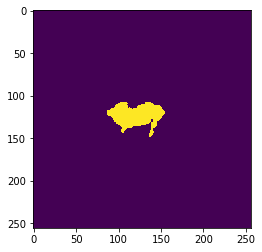

In [6]:
print('Slice from 4D array ')
slice = 80
plt.imshow(mask_4D[:,:,slice,0]) #0 pour ROI 1
plt.show()

### CT RTSS to CT array 

In [ ]:
mask_builder_rtss = MaskBuilder_RTSS(rtss_path, ct_path)

In [ ]:
from time import process_time
t1_start = process_time()
mask_4D = mask_builder_rtss.rtss_to_4D_mask()
t1_stop = process_time() 
print("diff début fin :", t1_stop-t1_start)

In [ ]:
print("Number of ROI in RTSS : ", mask_builder_rtss.number_of_roi)
print("Size of array in CT Modality : ", mask_4D.shape)

In [ ]:
print('Slice from 4D array ')
slice = 105
plt.imshow(mask_4D[:,:,slice,0]) #0 pour ROI 1
plt.show()

## Mask -> RTSTRUCT file 


In [10]:
from library_dicom.export_segmentation.ExportSegmentation_Writer import ExportSegmentation_Writer
import pydicom

In [8]:
writer = ExportSegmentation_Writer(mask_4D, pet_path, mode='rtstruct')

In [9]:
filename = 'rtstruct_test_v2.dcm'
directory_path =  r'C:\Users\wendy\Documents\STAGE\DicomRT\201802409 BARAT GALPIN ELIANE'
writer.generate_dicom(filename, directory_path)

In [3]:
from library_dicom.export_segmentation.ExportSegmentation_Writer import ExportSegmentation_Writer
from library_dicom.dicom_processor.tools.folders import *
from skimage.measure import label
import numpy as np

json_path = '/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome/pet_array_multiple_roi.json'
dataset = []
with open(json_path) as json_file : 
    reader = json.load(json_file)
    for info in reader :
        dataset.append(info)

pred = np.array(dataset)
print(np.max(pred))

#generate rtstruct file 
pet_path = '/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome/1.2.250.1.59.453.859.92444169.1516.1370594209.2.2.8'

writer = ExportSegmentation_Writer(pred, pet_path, mode='rtstruct')

filename = 'rtss_prediction_mask_pet_ExpVR_v5.dcm'
directory_path = '/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome'
writer.generate_dicom(filename, directory_path)

20
